# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [ ]:
candidateno=249694 #this MUST be updated to your candidate number so that you get a unique data sample


In [ ]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['the', 'event', 'of', 'events', 'is', 'upon', 'us', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [ ]:
from nltk.stem import WordNetLemmatizer
#Importing the required dependancies for the lemmatizer tool in the nltk library
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
#Comprehension goes through every (review,label) pair in training data and stores the resultant (review with number tokens as 'NUM',label)
training_num = [(['NUM' if j.isdigit() else j for j in i[0]],i[1]) for i in training_data]
#for every token in review, for review in every (review,label) pair in training_num, return the root (lemmatized) version of the token if it is not a stopwords and is alphanumeric (no glyphs)
training_norm = [([lemmatizer.lemmatize(j) for j in i[0] if j.isalpha() and j not in stopwords.words('english')],i[1]) for i in training_num]

#setting frequency distrubutions variables
pos_freq_dist = FreqDist()
neg_freq_dist = FreqDist()
#if label in (review,label) is postitive add to pos Frequency distrbiution, and vice versa for Negative
for words,label in training_norm:

  if label == 'pos':
    pos_freq_dist.update(words)
  else:
    neg_freq_dist.update(words)
#We are not left with every word to have occured in each type of review, as well as the amount of occurances




[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:


def derive_list_from_difference(df1,df2,upto):

  #Derives list object from the difference in the FreqDist Values of 1 dataset to another
  #Finds a dataset used to differentiate type/label data set from another

  #param df1: the dataset to which the resultant wordlist will pertain to
  #param df2: the dataset of the opposing label, against which we compare the frequencies of fd1 against
  #param size: cutoff for the wordlist length

  #make list from token:frequency pairs (descending in frequency) in df which we're making a wordlist for (df1), and for each pair create a (token:difference in occurance df1->df2) term in list
  #I could adjust for the difference in training data size foe each set but I will not to allow for disparitites testing outcomes to come through
  freq_list = [(pair[0],round(pair[1]-(df2.get(pair[0])))) for pair in df1.items() if df2.get(pair[0]) is not None]
  #sorts the list by the frequency in descending (reverse = True) order by the key of the frequency of each term in order to create the list from the most relevant terms
  freq_list = sorted(freq_list, key = lambda x: x[1], reverse = True)
  #returns the most common words used used to identify one dataset from another but without the frequency in a list data strcuture
  print(freq_list)
  word_list = [i[0] for i in freq_list]
  #truncates word_list to param:upto
  return word_list[0:upto]

#Creating positive and negative word lists from previously defined method
#a)
pos_word_list = derive_list_from_difference(pos_freq_dist,neg_freq_dist,10)
#b)
neg_word_list = derive_list_from_difference(neg_freq_dist,pos_freq_dist,10)




[('film', 713), ('life', 418), ('story', 339), ('also', 283), ('best', 233), ('world', 216), ('one', 215), ('well', 215), ('great', 213), ('many', 207), ('performance', 194), ('love', 189), ('see', 178), ('war', 176), ('alien', 159), ('time', 149), ('family', 142), ('way', 135), ('american', 133), ('year', 132), ('character', 124), ('people', 116), ('star', 115), ('perfect', 112), ('show', 112), ('take', 111), ('man', 110), ('black', 110), ('quite', 110), ('however', 109), ('jackie', 109), ('first', 107), ('mother', 107), ('although', 106), ('true', 104), ('truman', 104), ('seen', 102), ('new', 101), ('job', 99), ('yet', 95), ('u', 94), ('especially', 91), ('right', 91), ('picture', 90), ('different', 89), ('young', 88), ('role', 86), ('men', 86), ('day', 84), ('father', 84), ('disney', 84), ('feel', 81), ('oscar', 81), ('dark', 80), ('find', 80), ('may', 80), ('make', 79), ('cameron', 79), ('reality', 78), ('fiction', 77), ('trek', 76), ('view', 74), ('others', 73), ('viewer', 73), ('

To generate any amount of words from a corpus I would need to find the frequency of each token, normalise them, rank them by frequency, and a wordlist of any length could be derived by cutting the descending frequency list at a desired point.
I began by importing WordNetLemmatiser from the nltk library, this is a crucial part of the normalisation process. Lemmatization gives us the stem of any word, meaning that different tenses/variations of a word won’t count as separate tokens. I also import ‘wordnet’, a dependency required for the lemmatizer and instantiate a lemmatizer object.

The training_num variable contains a list created through a comprehension that aims to achieve number normalisation (replacing every number with ‘NUM’), it does this by going through every (review,label) pair in training data and in creates a corresponding (review with number tokens as 'NUM',label) in the list. The training_norm variable contains a list created from a comprehension which for every token in review, for review in every (review,label) pair in training_num, returns the root (lemmatized) version of the token if it is not a stopwords (redundant information) and is alphanumeric (no glyphs)

I then created 2 Frequency Distribution objects from the NLTK library, 1 for positive tokens and one for negative tokens. These store items as token: frequency pairs, which can be changed by feeding in lists of tokens. I then, for every review, added the total normalised words in a review into its (positive or negative FreqDist). We are now left with 2 data structures containing the sum occurrences of each word based the label of the review.

To build the word list, I created the derive_list_from_difference(df1,df2,upto), where df1 is the FreqDist of tokens in the class we’re building a wordlist for, df2 being the class we’re trying to distinguish from, and upto being the cutoff point for the wordlist. The freq_list variable stores a list from a comprehension which goes through all items in df1(.items()), and if the token is in df2, will create a tuple (token in both dataframes, value of token in df1 - value of token in df2). This creates the list of differences of occurrence, and the tokens with the least negative numbers are the most useful for our wordlists. I could’ve normalised the two dataframes for size but decided not to in order to observe the effects of not having done so. The following line, as it is no longer a FreqDist object, can no longer have the most_common() method called so sort by frequency, so I used the statics sorted method by the key of the frequencies in reverse order, giving us a descending list of token,freq descending by freq. I then removed the frequencies via comprehension and returned up to (upto) the term specified in the method’s arguments.

To create the two wordlists, I simply found the differences of positive to negative review token occurrence (pos list) and the vice versa of the two sets using the same method (neg list) up to 10 to make both required lists.


2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [ ]:
#I have define the WordListClassifier and made it a subclass of ClassifierI, in order to be able to use it's classify_many method
class WordListClassifier(ClassifierI):
  #The class takes 2 parameters, one of positive and one of a negative wordlist
  def __init__(self,pos,neg):
    self.pos = pos
    self.neg = neg

  def classify(self,doc):
    #We set the score to be neutral to begin with
    score = 0
    #for each token in list, if it is in the positive wordlist, increment the score
    for word in doc:
      if word in self.pos:
        score += 1
        #if the token is in the negative wordlist, decrement the score
      elif word in self.neg:
        score -= 1
    #Return a classification for the document depending on whether the score sums up to a positive or negative digit
    if score > 0:
      return 'pos'
    elif score < 0:
      return 'neg'
    #In order have the same amount of outputs as the amount of times this method is called (ie in ClassifierI.classify_many()) it will randomly return a value in the rare
    #-case it is neutral. This is a small sacrifice in accuracy
    return random.choice(['pos','neg'])




To create my WL classifier I first created a class inheriting from ClassifierI in the NLTK library, this ensured that having implemented classifier.classify(doc) the same classifier could use classify_many() with no added work later on. I instantiate the class with a positive word-list (pos) and a negative word-list (neg) parameters. For the classify method I simply created a variable score which will be our basis for class judgement. I then, for every token in the doc, checked for the tokens presence in the list. If found in the positive list, I would increment score by 1, if negative I would decrement score by 1. By the end I would hopefully have an integer value that is either positive or negative, for which I would return a corresponding ‘pos’ or ‘neg’ label for. In the case that the document has even token sentiment, I would return a value that is picked by 50/50 chance. As we will likely be using this classifier on many documents at once, the minute chance of a misleading classification will likely be lost in the correct classifications by numerous other (hopefully) correct classifications.


3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [ ]:
class EvaluateClassifier():
  #I have put the calculation of the creation of the review_result_pair list in the constructor for runtime reasons,
  #-as to only do it once, knowing that we need it for every method in the class
  def __init__(self,labelled_data,classifier):
    #initialises classifier and labelled data set in constructor
    self.classifier = classifier
    self.ld = labelled_data
    #seperating label and review pairs in order to be able to manage them easier
    reviews,labels = zip(*self.ld)
    #Creates a list of review results for
    classifier_results = self.classifier.classify_many(reviews)
    #Creating an easily iterable data structure pertaining to classifier performance, as to not need to first-hand access to our classifier or data after we do this
    self.review_result_pairs = []
    ptr = 0
    #classifier_results and labels are both pertaining to the same review at the same index of the the lists, hence we can simply call both arrays at index ptr and join them into a pair
    #this is a while loop that does this from ptr 0-> n
    while ptr < len(labels):
      self.review_result_pairs += [(labels[ptr],classifier_results[ptr])]
      ptr += 1
    #Constructs Confusion Matrix values as fields, check get_confusion_matrix() method
    self.TP,self.TN,self.FP,self.FN = self.get_confusion_matrix()


  def accuracy(self):

    #The method considers a document correctly labelled if a (classification,label) pair is the same
    #Finds the accuracy by finding the amount of such documents in the review_result_pair list divided by the total number of documents looked at

    total = len(self.ld)
    correctly_labelled = 0
    for pair in self.review_result_pairs:
      if pair[0] == pair[1]:
        correctly_labelled += 1
    return correctly_labelled / len(self.ld)

  def get_confusion_matrix(self):
    TP,TN,FP,FN = 0,0,0,0
    for pair in self.review_result_pairs:
      #True Positives: The amount of time the classifier classified (pair[1]) a Positive document is actually labelled (pair[0]) Positive
      if pair[1] == 'pos' and pair[0] == 'pos':
          TP += 1
      #True Negativess: The amount of time the classifier classified (pair[1]) a Negative document is actually labelled (pair[0]) Negative
      elif pair[1] == 'neg' and pair[0] == 'neg':
          TN += 1
      #False Positives: The amount of time the classifier classified (pair[1]) a Positive document is actually labelled (pair[0]) Negative
      elif pair[1] == 'pos' and pair[0] == 'neg':
          FP += 1
      #False Negative: The amount of time the classifier classified (pair[1]) a Negative document is actually labelled (pair[0]) Positive
      elif pair[1] == 'neg' and pair[0] == 'pos':
          FN += 1
    return TP,TN,FP,FN

  def precision(self):
    #Precision: the proportion documents classified as positive to be truly positive
    return self.TP / (self.TP + self.FP)

  def recall(self):
    #Recall: the proportion of positive documents to be classified as positive
    return self.TP / (self.TP + self.FN)

  def f1(self):
    #F1: A value to take in account of a classification model's precision and Recall, an overall measure of performace, leans towards the lower of the two values
    P = self.precision()
    R = self.recall()
    f1 = (2*P*R) / (P+R)
    return f1

  #Method to change the data and classifier of an EvaluateClassifier object, resembles constructor
  def change_test_data(self,labelled_data,classifier):
    self.classifier = classifier
    self.ld = labelled_data
    reviews,labels = zip(*self.ld)
    classifier_results = self.classifier.classify_many(reviews)
    self.review_result_pairs = []
    ptr = 0
    while ptr < len(labels):
      self.review_result_pairs += [(labels[ptr],classifier_results[ptr])]
      ptr += 1
    self.TP,self.TN,self.FP,self.FN = self.get_confusion_matrix()



In [ ]:
#Results of a WordList Classifier
wclass = WordListClassifier(pos_word_list,neg_word_list)
evaluator = EvaluateClassifier(testing_data,wclass)
print(f'Accuracy: {evaluator.accuracy()} \nPrecision: {evaluator.precision()}\nRecall: {evaluator.recall()}\nF1: {evaluator.f1()}')

Accuracy is an adequate initial measure of the performance of a classifier under the assumption of a balanced dataset, and cost of a false negative and a false positive being the same. If we are unsure about these metrics, Accuracy can be misleading as it gives no indication as to where its failures lie.

One example could be a case in which a classifier has an extremely low classification threshold for positive documents due to its skewed wordlist, and is given a testing set in which most of the documents are positive. The classifier will most likely score very highly in terms of accuracy, but will give no hint to its lack of success in correctly identifying negative documents. To be able to correctly judge the performance of a classifier we would need to use all 4 Accuracy, Precision, Recall, and (by extension) F1 metrics, as these give us an idea of classifier and test dataset bias via proportion of correct positive classifications (Precision) and the proportion positive documents being classified as such (Recall), with F1 being a derivative metric to account for both.


4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

In [ ]:
import numpy as np

class NBClassifier(ClassifierI):

  def __init__(self):
    #The container for the {feature: P(f|pos), P(f|neg)} items for each item the training vocab
    self.feat_probs = {}
    #Probability of each document being a certain class {class=pos,neg: P(c=class)}
    self.class_probs = {}
    #Set of all words we enecounter in the training data
    self.all_words = set()

  def normalise_text(self,uncleaned_tokens):
    #Previosuly seen cleaning method
    tokens_num = ['NUM' if i.isdigit() else i for i in uncleaned_tokens ]
    tokens_norm = [lemmatizer.lemmatize(i) for i in tokens_num if i not in stopwords.words('english') and i.isalpha()]
    return tokens_norm

  def train(self,labelled_data):

    #Preprocess the data
    text_norm = [(self.normalise_text(i[0]),i[1]) for i in labelled_data]

    #P{class=pos,neg: number of documents c=class in training data}
    num_docs = {}
    for document,label in text_norm:
      if label not in num_docs:
        num_docs[label] = 1
      else:
        num_docs [label] += 1
    #At this point feat_probs does not actually contain probabilities, only the amount times the tokens been seen
      doc_freq = FreqDist(document)
      for feat,freq in doc_freq.items():
        #Adds new words to set, if in list, does nothing as it is a set
        self.all_words.add(feat)
        #Initialises word as key in dictionary, with label doc as the subkey
        if feat not in self.feat_probs:
          self.feat_probs[feat] = {label: 1}
        #Adds label subkey if token seen but label subkey not present
        elif label not in self.feat_probs[feat]:
          self.feat_probs[feat][label] = 1
        #else increment token,label count
        else:
          self.feat_probs[feat][label] += 1

    #P(C = (pos,neg)) = amount of occurances of label c docs / total amount of docs
    for label in num_docs:
      self.class_probs[label] = num_docs[label] / len(text_norm)
      #Setting up for smoothing in order to not distrupt results when we find the Product of all feature probabilities
      for feat in self.feat_probs:
        if label not in self.feat_probs[feat]:
          self.feat_probs[feat][label] = 0
        #We now turn the frequencies of every token in each class to a probability
        #Laplace Smoothing :Add 1 to every count of label in every feature, Add 2 to every count of documents to account for 2 new cases created
        self.feat_probs[feat][label] = ((self.feat_probs)[feat][label] + 1) / (num_docs[label] + 2)


  def classify(self,document):
    #Allows for the entry of either a labelled (document,label) pair or simply a document
    if type(document) is tuple:
      text = set(self.normalise_text(document[0]))
    else:
      text = set(self.normalise_text(document))

    probabilities = {}

    for label in self.class_probs:
      #We use logs as probabilities in order to represent our probabilities as if we multiplied raw decimals we would quickly reach decimal overflow
      #P(c)
      probabilities[label] = np.log(self.class_probs[label])

      #P(f|c).P(c)
      for word in self.all_words:
        if word in text:
                  #We add rather than multiply the values as log(a*b*c*...) = log(a) + log(b) + log(c) +...
                  #In the case of the word not being present we default to a smoothed value
                  probabilities[label] += np.log(self.feat_probs[word].get(label, 1/(len(self.all_words) + 2)))
        #In case of the word not being there, we add the probability of the absense of a value in order to avoid underflow issues
        else:
            probabilities[label] += np.log(1 - self.feat_probs[word].get(label, 1/(len(self.all_words) + 2)))

    return max(probabilities, key=probabilities.get)

In [ ]:
nbclassifier = NBClassifier()
nbclassifier.train(training_data)

In [ ]:
print(f'WordList Classifier\n\n\nAccuracy: {evaluator.accuracy()} \nPrecision: {evaluator.precision()}\nRecall: {evaluator.recall()}\nF1: {evaluator.f1()} \n\n\n\'')
evaluator = EvaluateClassifier(testing_data,nbclassifier)
print(f'Naive Bayes Classifier\n\n\nAccuracy: {evaluator.accuracy()} \nPrecision: {evaluator.precision()}\nRecall: {evaluator.recall()}\nF1: {evaluator.f1()}')
#The Wordlist Classifier has noticably low Acurracy, Precision but an astoundingly large Recall. This could signify that the decision boundary is skewed heavily towards the
#positive, as it producing FP 40% of the time c = pos. This is an indicator or a larger positively labelled data set, as there are words that will appear in the negative reviews more
#prominant proportionally but might not make an impact simply due to a lrger sample size in docs where c = pos.
#For the Naive Bayes Bernoulli Classifier, accuracy seems to be a lot higher, as well as the precision. The higher amount of negative classifications is because features
#that are prominent in one class might affect the likelihood of the opposing classification with its absence, preventing the low positive classification threshold we in the WL classifier.
# Hence the lower recall despite the positive-skewed training set as shown by our derived wordlists.
#Though both classifiers seem to have a high F1 score, the WL classifier only competes due to its astounding accuracy in categoring positive reviews correctly. Given a dataset with
#similar token distribution and a larger proportion of negative reviews, it would likely have a classification rate than a 50/50 coinflip.

WordList Classifier


Accuracy: 0.6083333333333333
Precision: 0.5664621676891616
Recall: 0.9233333333333333
F1: 0.7021546261089987


'
Naive Bayes Classifier


Accuracy: 0.7766666666666666
Precision: 0.8487394957983193
Recall: 0.6733333333333333
F1: 0.7509293680297398

If we look at the Accuracy metric we can see the NB classifier highly outperforming the WordList classifier. The WL classifier was only 20% better than a coinflip in this metric. The reason for this can evidently be seen in its precision of 0.56, meaning it was nearly the same amount of false positives as true  positives. This could pertain to a positively skewed wordlist, as the testing set had an even number of negative and positive reviews. Furthermore we can see its recall is nearly 0.92, having classified nearly all positive reviews as such, though that again, could be attributed to a low positive classification threshold.
This skewing can happen when the disparities for class-defining words are larger for one set than another, ie ‘film’ for positive = df1(‘film’) - df2(‘film’) = ~700, ‘movie’ for neg = df2(‘movie’) - df1(‘movie’) = ~500

The NB Classifier seemed to have a significantly more even distribution of classifications. Having an extremely high accuracy as well as a precision rating. This means that the amount of false positives was significantly lower despite both models being based on the same training data. This is likely to NB classifiers still having the ability to fall back on the absence of words distinctive to a class to make judgements despite a biassed training set, meaning it is not as susceptible to biased training data. Its recall was significantly lower meaning, that there could have been some overlap between words used in both types of reviews, their feature probability for each class not being particularly telling as to which one it is.

Overall both classifiers had a similar F1 score, WL scoring only 5% less, but that was only due to its extremely large recall. This leaves it as not a particularly useful classifier compared to the more well rounded NB classifier, only performing well in positive-heavy testing-set


5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


In this experiment our independent variable is the Wordlist size. To begin with I made a list of the wordlist sizes we were going to use. I decided to include 0, to see how it would perform, which by my prediction was going to be a 50/50 chance for any classification. I chose 30000 as the top value as I would like to see how the classifier performs when the words being used towards the tail end of the list are no longer that relevant or distinguishing to a particular class. 30000 is over half of the token in the total training set, and hence I assumed it was going to cause problems.

I created a wordlist by cycling through the values size value list, using the derive_list_from_difference() method in order to keep wordlist generation consistent, in case truncating a 30000 wordlist for each value resulted in imprecise results.

I then fed the wordlists through a WL classifier, which I then used in my EvauluateClassifier class. This generated a 4-length tuple (Accuracy,Precision,Recall,F1) for each size, along with size as key. I found this convenient as I could simply reference the size to collect all the data from the evaluator. I then split the tuples into 4 lists, all of which were to be used as data-points in the pandas dataframe.

For the dataframe, I set our 4 dependent variables as belonging to each key in our index of the word list size word_list_sizes. I then created my own colour palette for the data, and made the bars wider (colours list, width=.8), as the preset barchart layout was hard to follow.  I also cut the displayed data to only show above 0.4 on the y axis as the differences in performance were more visible.

As we can see from the data, there is an evident bell-curve with regards to performance. We can see towards the end the curve the classifier stops behaving as intended, as Recall is at 1.0 after this point it is safe to assume the classifier defaults to a positive position as having more than half of the sets tokens in a class will make it stop it from being able to identify the other class. The part at which the performance peaks can be seen at size = 2000, this is about 1/50th of the dataset. At this point we can see the highest Accuracy, Precision and F1, but a Recall that dips slightly compared to neighbouring sizes. This could indicate a level at which both the negative and positive wordlists have enough words to be classified effectively.




In [ ]:
#Independant Variable: WordList size
#Dependant Variables: Classifier used, training data, training data
wordlist_pairs = {}
#I decided to have the wordlist size increase in magnitudes, also including 0 in order to compare against the baseline accuracy of a random 50/50 choice
#as well as including 4000, which would certainly begin to have terms no longer relevant or conversely relevant to the class we are training for.
word_list_sizes = [0,3,10,20,50,100,500,1000,2000,4000,8000,16000,30000]
#I created 2 wordlists (pos,neg) for each word list size and stored them into a dictionary from previosuly defined static methods
for size in word_list_sizes:
  wordlist_pairs[size] = (derive_list_from_difference(pos_freq_dist,neg_freq_dist,size),derive_list_from_difference(neg_freq_dist,pos_freq_dist,size))

In [ ]:
classifier_test_results = {}
test_results = {}

#I then fed the wordlists into a WL Classifier and then used that in my previously made ClassifierEvaluator, storing the results as (size: acc,prec,rec,f1) key value pairs in
#a dictionary
for size, (pos, neg) in wordlist_pairs.items():
  classifier = WordListClassifier(pos,neg)
  evaluator = EvaluateClassifier(testing_data,classifier)
  test_results[size] = (evaluator.accuracy(),evaluator.precision(),evaluator.recall(),evaluator.f1())

test_results

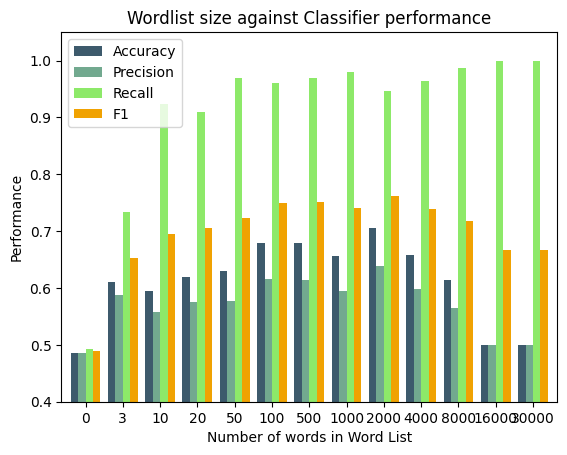

In [ ]:
#I then extracted each of these out of the key value pairings to create value sets for the pandas dataframe
dp_accuracy = [accuracy for size,(accuracy,_,_,_) in test_results.items()]
dp_precision = [precision for size,(_,precision,_,_) in test_results.items()]
dp_recall = [recall for size,(_,_,recall,_) in test_results.items()]
dp_f1 = [f1 for size,(_,_,_,f1) in test_results.items()]

#As we were comparing the effect of wordlist sizes on the 4 dependant variables, I made the size the key
df = pd.DataFrame({'Accuracy': dp_accuracy,'Precision': dp_precision,
                  'Recall': dp_recall,'F1':dp_f1}, index=word_list_sizes)


#As the default colours were slightly hard to follow I introduced some new ones using hexadecimals
colours = ['#3D5A6C','#72A98F','#8DE969','#F0A202']
#The best plot for this seems like a bar graph as it would be able to show all the seperate values as well as a generally growing f1 as size increases going away from size = 0
ax = df.plot.bar(rot=0, width = 0.8,color=colours)
ax.set_xlabel('Number of words in Word List')
ax.set_ylabel('Performance')
ax.set_title('Wordlist size against Classifier performance')
#The disparities of the graph were not as prominent when the raw graph was presented so I cut the graph off y < 0.4
ax.set_ylim(0.4,1.05)
plt.show()


#b) I would reccomend the naive bayes classifier as it is probability based, meaning that more prominent words have a higher weight on the outcome of the classification.
#Though easier to build, and a lot faster in time taken to classify, WordList classifiers can be very biased  if not trained using a
# balanced training dataset. An NB can also use the probability of a feature not appearing in a document in its class, giving some leeway if it's training data skews towards one side.
#If I the data that I needed to analyse was extremely large and the field was rich with polarising sentiment words, I would use the wordlist classifier, in most other cases I would
#Go for the NB Classifier option.






b) A wordlist classifier is an extremely effective tool in cases where the dataset we use to derive wordlists from is extremely balanced, and data we classify has many context-free sentiment-indicating tokens. In such situations it would be more advantageous to use a WL classifier as it is significantly more simple and will run way faster with less space taken up.

Saying this, from our comparisons we can see that the NB classifier performed significantly better all around, despite the evidently biased training_set. An NB classifier weighs the result (via probability) depending on how prominent a term is in a class, as well as uses the lack of an appearance of term to as an indicator of class, which make it more useful on a wider range of datasets. Due to these advantages, and measurable differences in performance, I am more likely to use the NB classifier in future work.



In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/NLEassignment2023.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))